In [1]:
pip install scikit-fuzzy

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [28]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt 

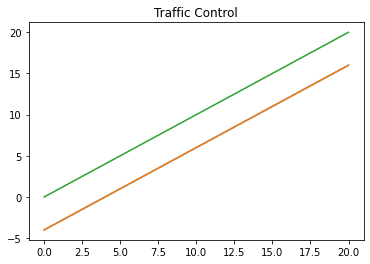

In [29]:
x_behind_red_light = np.arange(-4, 17, 1)
plt.plot(x_behind_red_light)
x_arriving_green_light = np.arange(-4, 17, 1)
plt.plot(x_arriving_green_light)
x_extension = np.arange(0, 21, 1)
plt.plot(x_extension)
plt.title('Traffic Control')

arriving_green_light_few = fuzz.trimf(x_arriving_green_light, [0, 0, 3])
arriving_green_light_small = fuzz.trimf(x_arriving_green_light, [0, 3, 6])
arriving_green_light_medium = fuzz.trimf(x_arriving_green_light, [3, 6, 9])
arriving_green_light_many = fuzz.trimf(x_arriving_green_light, [6, 9, 12])

behind_red_light_few = fuzz.trimf(x_behind_red_light, [0, 0, 3])
behind_red_light_small = fuzz.trimf(x_behind_red_light, [0, 3, 6])
behind_red_light_medium = fuzz.trimf(x_behind_red_light, [3, 6, 9])
behind_red_light_many = fuzz.trimf(x_behind_red_light, [6, 9, 12])

extension_zero = fuzz.trimf(x_extension, [0, 0, 0])
extension_short = fuzz.trimf(x_extension, [0, 2, 4])
extension_medium = fuzz.trimf(x_extension, [2, 4, 6])
extension_long = fuzz.trimf(x_extension, [4, 6, 8])

In [30]:
def get_extension(arriving_green_light_car, behind_red_light_car, extension_count):
        behind_red_light_level_few = fuzz.interp_membership(x_behind_red_light, behind_red_light_few, behind_red_light_car)
        behind_red_light_level_small = fuzz.interp_membership(x_behind_red_light, behind_red_light_small, behind_red_light_car)
        behind_red_light_level_medium = fuzz.interp_membership(x_behind_red_light, behind_red_light_medium, behind_red_light_car)
        behind_red_light_level_many = fuzz.interp_membership(x_behind_red_light, behind_red_light_many, behind_red_light_car)

        arriving_green_light_level_few = fuzz.interp_membership(x_arriving_green_light, arriving_green_light_few, arriving_green_light_car)
        arriving_green_light_level_small = fuzz.interp_membership(x_arriving_green_light, arriving_green_light_small, arriving_green_light_car)
        arriving_green_light_level_medium = fuzz.interp_membership(x_arriving_green_light, arriving_green_light_medium, arriving_green_light_car)
        arriving_green_light_level_many = fuzz.interp_membership(x_arriving_green_light, arriving_green_light_many, arriving_green_light_car)

        # Rule 1: If Arrival is few then Extension is zero.
        # Rule 2: If Arrival is small AND Queue is (few OR small) then Extension is short.
        # Rule 3: If Arrival is small AND Queue is (medium OR many) then Extension is zero.
        # Rule 4: If Arrival is medium AND Queue is (few OR small) then Extension is medium.
        # Rule 5: If Arrival is medium AND Queue is (medium OR many) then Extension is short.
        # Rule 6: If Arrival is many AND Queue is few then Extension is long.
        # Rule 7: If Arrival is many AND Queue is (small OR medium) then Extension is medium.
        # Rule 8: If Arrival is few AND Queue is many then Extension is short.

        rule1 = arriving_green_light_level_few
        rule2 = np.fmin(arriving_green_light_level_small,
                        np.fmax(behind_red_light_level_few, behind_red_light_level_small))
        rule3 = np.fmin(arriving_green_light_level_small,
                        np.fmax(behind_red_light_level_medium, behind_red_light_level_many))
        rule4 = np.fmin(arriving_green_light_level_medium,
                        np.fmax(behind_red_light_level_few, behind_red_light_level_small))
        rule5 = np.fmin(arriving_green_light_level_medium,
                        np.fmax(behind_red_light_level_medium, behind_red_light_level_many))
        rule6 = np.fmin(arriving_green_light_level_many, behind_red_light_level_few)
        rule7 = np.fmin(arriving_green_light_level_many,
                        np.fmax(behind_red_light_level_small, behind_red_light_level_medium))
        rule8 = np.fmin(arriving_green_light_level_many, behind_red_light_level_many)

        if extension_count == 0:
            extension_activation_zero = np.fmin(np.fmax(rule1, rule3), extension_zero)
            extension_activation_short = np.fmin(np.fmax(rule2, np.fmax(rule5, rule8)), extension_short)
            extension_activation_medium = np.fmin(np.fmax(rule4, rule7), extension_medium)
            extension_activation_long = np.fmin(rule6, extension_long)

        else:
            extension_activation_zero = np.fmin(
                np.fmax(rule1, np.fmax(rule2, np.fmax(rule3, np.fmax(rule5, rule8)))), extension_zero)
            extension_activation_short = np.fmin(np.fmax(rule4, rule7), extension_short)
            extension_activation_medium = np.fmin(rule6, extension_medium)
            extension_activation_long = np.fmin(0, extension_long)

        aggregated = np.fmax(extension_activation_zero, np.fmax(extension_activation_short,
                                                                np.fmax(extension_activation_medium,
                                                                        extension_activation_long)))

        return fuzz.defuzz(x_extension, aggregated, 'centroid')

In [33]:
get_extension(7,2,9)

2.714285714285715